In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [3]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *
from desc.io import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

print_backend_info()

DESC version=0.15.0+555.g9b2e71684.dirty.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 9.57 GB available memory.


# 3D Interpolation with Fourier-Chebyshev

Double Fourier in toroidal and poloidal direction, Chebyshev in radial direction.

In [191]:
def get_fc_coeffs(z, L):
    zl = jax.scipy.fft.dct(z, axis=1, norm=None)
    zl = zl.at[:, 0, :].divide(2)
    zl /= L
    # FFT coeffs are also unnormalized, need to divide by M
    zlm = jnp.fft.fft(zl, axis=2, norm=None)
    zlmn = jnp.fft.fft(zlm, axis=0, norm=None)
    return zlmn

In [192]:
from desc.particles import *
from diffrax import *

class VacuumGuidingCenterTrajectoryFit(AbstractTrajectoryModel):
    vcoords = ["vpar"]
    args = ["m", "q", "mu"]

    def __init__(self, frame):
        assert frame in ["lab", "flux"]
        self._frame = frame

    @property
    def frame(self):
        """Coordinate frame of the model."""
        return self._frame

    @jit
    def vf(self, t, x, args):
        x = x.squeeze()
        model_args, data, _, _ = args
        m, q, mu = model_args

        xp, yp, zeta, vpar = x
        rho = jnp.sqrt(xp**2 + yp**2)
        theta = jnp.arctan2(yp, xp)
        # compute functions are not correct for very small rho
        rho = jnp.where(rho < 1e-6, 1e-6, rho)

        r0p = 1 - 2 * rho
        Tl = jnp.cos(data["l"] * jnp.arccos(r0p))
        expm = jnp.exp(1j * data["m"] * theta) / data["M"]
        expn = jnp.exp(1j * data["n"] * zeta) / data["N"]

        def interpolate(cf):
            f_l = jnp.einsum("nlm,l->nm", cf, Tl)
            f_lm = jnp.einsum("nm,m->n", f_l, expm)
            f_lmn = jnp.einsum("n,n->", f_lm, expn)
            return jnp.real(f_lmn)

        Br = interpolate(data["Br"])
        Bp = interpolate(data["Bp"])
        Bz = interpolate(data["Bz"])
        B = jnp.array([Br, Bp, Bz])
        magB = jnp.linalg.norm(B)
        b = B / magB

        gBr = interpolate(data["gBr"])
        gBp = interpolate(data["gBp"])
        gBz = interpolate(data["gBz"])
        gradB = jnp.array([gBr, gBp, gBz])

        er_r = interpolate(data["er_r"])
        er_p = interpolate(data["er_p"])
        er_z = interpolate(data["er_z"])
        er = jnp.array([er_r, er_p, er_z])

        et_r = interpolate(data["et_r"])
        et_p = interpolate(data["et_p"])
        et_z = interpolate(data["et_z"])
        et = jnp.array([et_r, et_p, et_z])

        ez_r = interpolate(data["ez_r"])
        ez_p = interpolate(data["ez_p"])
        ez_z = interpolate(data["ez_z"])
        ez = jnp.array([ez_r, ez_p, ez_z])

        Rdot = vpar * b + (
            (m / q / magB**2) * ((mu * magB / m) + vpar**2) * cross(b, gradB)
        )
        # take dot product for rho, theta and zeta coordinates
        rhodot = dot(Rdot, er)
        thetadot = dot(Rdot, et)
        zetadot = dot(Rdot, ez)

        # get the derivative for cartesian-like coordinates
        xpdot = rhodot * jnp.cos(theta) - rho * thetadot * jnp.sin(theta)
        ypdot = rhodot * jnp.sin(theta) + rho * thetadot * jnp.cos(theta)
        # derivative the parallel velocity
        vpardot = -mu / m * dot(b, gradB)
        dxdt = jnp.array([xpdot, ypdot, zetadot, vpardot]).reshape(x.shape)
        return dxdt.squeeze()

In [193]:
name = "precise_QA"
try:
    # if the file exists, load it
    eq = load(f"{name}_vacuum_scaled_solved.h5")
    eqi_scaled = eq.copy()
except:
    # else, create it from scratch
    eqi = get(name)
    eq = rescale(eq=eqi, L=("a", 1.7044), B=("<B>", 5.86), copy=True)
    eq.pressure = 0
    eq.current = 0
    eq.solve(ftol=1e-4, verbose=1)
    eqi_scaled = eq.copy()
    eq.save(f"{name}_vacuum_scaled_solved.h5")
    
eq.iota = eq.get_profile("iota")
L = 32
M, N = 32, 32
k = np.arange(L)
x = jnp.cos(jnp.pi * (2 * k + 1) / (2 * L))

rho = (x + 1) / 2
grid = LinearGrid(rho=rho, M=M, N=N, sym=False, NFP=1)
data = eq.compute(["B", "grad(|B|)", "e^rho", "e^theta", "e^zeta"], grid=grid)
Br = data["B"][:, 0]
Bp = data["B"][:, 1]
Bz = data["B"][:, 2]

gBr = data["grad(|B|)"][:, 0]
gBp = data["grad(|B|)"][:, 1]
gBz = data["grad(|B|)"][:, 2]

err = data["e^rho"][:, 0]
erp = data["e^rho"][:, 1]
erz = data["e^rho"][:, 2]

etr = data["e^theta"][:, 0]
etp = data["e^theta"][:, 1]
etz = data["e^theta"][:, 2]

ezr = data["e^zeta"][:, 0]
ezp = data["e^zeta"][:, 1]
ezz = data["e^zeta"][:, 2]

/CODES/DESC/desc/utils.py:572: UserWarning: Setting rotational transform profile on an equilibrium with fixed toroidal current, removing existing toroidal current profile.
  warnings.warn(msg, err)
/CODES/DESC/desc/utils.py:572: UserWarning: Unequal number of field periods for grid 1 and basis 2.
  warnings.warn(msg, err)
/CODES/DESC/desc/utils.py:572: UserWarning: Unequal number of field periods for grid 1 and basis 2.
  warnings.warn(msg, err)


In [194]:
def reshape(arr):
    return arr.reshape(grid.num_zeta, grid.num_rho, grid.num_theta)

Br, Bp, Bz, gBr, gBp, gBz, err, erp, erz, etr, etp, etz, ezr, ezp, ezz = map(
    reshape, (Br, Bp, Bz, gBr, gBp, gBz, err, erp, erz, etr, etp, etz, ezr, ezp, ezz)
)

In [195]:
data_keys = [
    "Br",
    "Bp",
    "Bz",
    "gBr",
    "gBp",
    "gBz",
    "er_r",
    "er_p",
    "er_z",
    "et_r",
    "et_p",
    "et_z",
    "ez_r",
    "ez_p",
    "ez_z",
]
vals = [Br, Bp, Bz, gBr, gBp, gBz, err, erp, erz, etr, etp, etz, ezr, ezp, ezz]
data = {}
for key, val in zip(data_keys, vals):
    data[key] = get_fc_coeffs(val, L)

data["l"] = jnp.arange(L)
data["m"] = jnp.fft.fftfreq(2 * M + 1) * (2 * M + 1)
data["n"] = jnp.fft.fftfreq(2 * N + 1) * (2 * N + 1)
data["M"] = 2 * M + 1
data["N"] = 2 * N + 1

In [200]:
from desc.particles import _trace_particles

model = VacuumGuidingCenterTrajectoryFit(frame="flux")
model_org = VacuumGuidingCenterTrajectory(frame="flux")


def default_event(t, y, args, **kwargs):
    i = jnp.sqrt(y[0] ** 2 + y[1] ** 2)
    return jnp.logical_or(i < 0.0, i > 1.0)


event = Event(default_event)
T = 7
ts = np.linspace(0, 10 ** (-T), 100)
num = 10
rhos = [0.3] * num
initializer = ManualParticleInitializerFlux(
    rho0=rhos,
    theta0=0,
    zeta0=np.random.rand(num) * 2 * np.pi,
    xi0=2 * np.random.rand(num) - 1,
)
x0, args = initializer.init_particles(model=model, field=eq)

@jit
def fun(x0, args):
    rpz, _ = _trace_particles(
        field=data,
        y0=x0,
        model=model,
        model_args=args,
        ts=ts,
        params=None,
        max_steps=100000,
        min_step_size=1e-8,
        stepsize_controller=PIDController(rtol=1e-4, atol=1e-4, dtmin=1e-8),
        saveat=SaveAt(ts=ts),
        solver=Tsit5(),
        adjoint=RecursiveCheckpointAdjoint(),
        event=event,
        chunk_size=None,
        options={},
        throw=False,
        return_aux=False,
    )
    return rpz


@jit
def fun_org(x0, args):
    rpz, _ = _trace_particles(
        field=eq,
        y0=x0,
        model=model_org,
        model_args=args,
        ts=ts,
        params=eq.params_dict,
        max_steps=100000,
        min_step_size=1e-8,
        stepsize_controller=PIDController(rtol=1e-4, atol=1e-4, dtmin=1e-8),
        saveat=SaveAt(ts=ts),
        solver=Tsit5(),
        adjoint=RecursiveCheckpointAdjoint(),
        event=event,
        chunk_size=None,
        options={},
        throw=False,
        return_aux=False,
    )
    return rpz

In [201]:
fun_org(x0, args)

Array([[[0.3   , 0.    , 5.1876],
        [0.3   , 6.2826, 5.1864],
        [0.3   , 6.282 , 5.1851],
        [0.3   , 6.2814, 5.1839],
        [0.3   , 6.2808, 5.1826],
        [0.3   , 6.2802, 5.1813],
        [0.3   , 6.2796, 5.1801],
        [0.3   , 6.279 , 5.1788],
        [0.3   , 6.2784, 5.1776],
        [0.3   , 6.2778, 5.1763],
        [0.3   , 6.2772, 5.175 ],
        [0.3   , 6.2766, 5.1738],
        [0.3   , 6.276 , 5.1725],
        [0.3   , 6.2754, 5.1712],
        [0.3   , 6.2748, 5.17  ],
        [0.3   , 6.2741, 5.1687],
        [0.3   , 6.2735, 5.1675],
        [0.3   , 6.2729, 5.1662],
        [0.3   , 6.2723, 5.1649],
        [0.3   , 6.2717, 5.1637],
        [0.3   , 6.2711, 5.1624],
        [0.3   , 6.2705, 5.1611],
        [0.3   , 6.2699, 5.1598],
        [0.3   , 6.2693, 5.1586],
        [0.3   , 6.2687, 5.1573],
        [0.3   , 6.2681, 5.156 ],
        [0.3   , 6.2675, 5.1548],
        [0.3   , 6.2669, 5.1535],
        [0.3   , 6.2663, 5.1522],
        [0.3  

In [202]:
fun(x0, args)

/home/yigit/anaconda3/envs/gpu/lib/python3.12/site-packages/equinox/_jit.py:55: UserWarning: Complex dtype support in Diffrax is a work in progress and may not yet produce correct results. Consider splitting your computation into real and imaginary parts instead.
  out = fun(*args, **kwargs)


Array([[[0.3   , 0.    , 5.1876],
        [0.3   , 0.0008, 5.1864],
        [0.3   , 0.0016, 5.1851],
        [0.3   , 0.0024, 5.1839],
        [0.3   , 0.0032, 5.1826],
        [0.3   , 0.004 , 5.1813],
        [0.3   , 0.0048, 5.1801],
        [0.3   , 0.0057, 5.1788],
        [0.3   , 0.0065, 5.1776],
        [0.3   , 0.0073, 5.1763],
        [0.3   , 0.0081, 5.175 ],
        [0.3   , 0.009 , 5.1738],
        [0.3   , 0.0098, 5.1725],
        [0.3   , 0.0106, 5.1713],
        [0.3   , 0.0115, 5.17  ],
        [0.3   , 0.0123, 5.1687],
        [0.3   , 0.0131, 5.1675],
        [0.3   , 0.014 , 5.1662],
        [0.3   , 0.0148, 5.1649],
        [0.3   , 0.0157, 5.1637],
        [0.3   , 0.0165, 5.1624],
        [0.3   , 0.0174, 5.1611],
        [0.3   , 0.0182, 5.1599],
        [0.3   , 0.0191, 5.1586],
        [0.3   , 0.0199, 5.1573],
        [0.3   , 0.0208, 5.1561],
        [0.3   , 0.0217, 5.1548],
        [0.3   , 0.0225, 5.1535],
        [0.3   , 0.0234, 5.1523],
        [0.3  

In [199]:
x00 = x0[0]
params = eq.params_dict
%timeit model.vf(0, x00, [args[0], data, None, None])
%timeit model_org.vf(0, x00, [args[0], eq, params, {}])

550 μs ± 9.64 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.77 ms ± 125 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
model.vf(0, x00, [args[0], data, None, None])

In [ ]:
model_org.vf(0, x00, [args[0], eq, params, {}])

# No imaginary stuff

In [149]:
class VacuumGuidingCenterTrajectoryFitReal(AbstractTrajectoryModel):
    vcoords = ["vpar"]
    args = ["m", "q", "mu"]

    def __init__(self, frame):
        assert frame in ["lab", "flux"]
        self._frame = frame

    @property
    def frame(self):
        """Coordinate frame of the model."""
        return self._frame

    @jit
    def vf(self, t, x, args):
        x = x.squeeze()
        model_args, data, _, _ = args
        m, q, mu = model_args

        xp, yp, zeta, vpar = x
        rho = jnp.sqrt(xp**2 + yp**2)
        theta = jnp.arctan2(yp, xp)
        # compute functions are not correct for very small rho
        rho = jnp.where(rho < 1e-6, 1e-6, rho)

        r0p = 1 - 2 * rho
        Tl = jnp.cos(data["l"] * jnp.arccos(r0p))
        m_theta = data["m"] * theta
        expm_real = jnp.cos(m_theta) / data["M"]
        expm_imag = jnp.sin(m_theta) / data["M"]

        n_zeta = data["n"] * zeta
        expn_real = jnp.cos(n_zeta) / data["N"]
        expn_imag = jnp.sin(n_zeta) / data["N"]

        def interpolate(cf_real, cf_imag):
            # This function now manually performs complex arithmetic

            # 1. f_l = (cf_real + i*cf_imag) * Tl  (Tl is real)
            f_l_real = jnp.einsum("nlm,l->nm", cf_real, Tl)
            f_l_imag = jnp.einsum("nlm,l->nm", cf_imag, Tl)

            # 2. f_lm = (f_l_real + i*f_l_imag) * (expm_real + i*expm_imag)
            f_lm_real = jnp.einsum("nm,m->n", f_l_real, expm_real) - jnp.einsum(
                "nm,m->n", f_l_imag, expm_imag
            )
            f_lm_imag = jnp.einsum("nm,m->n", f_l_real, expm_imag) + jnp.einsum(
                "nm,m->n", f_l_imag, expm_real
            )

            # 3. f_lmn = (f_lm_real + i*f_lm_imag) * (expn_real + i*expn_imag)
            # We only need the final real part: Real(A*B) = A_real*B_real - A_imag*B_imag
            f_lmn_real = jnp.einsum("n,n->", f_lm_real, expn_real) - jnp.einsum(
                "n,n->", f_lm_imag, expn_imag
            )

            return f_lmn_real

        Br = interpolate(data["Br_real"], data["Br_imag"])
        Bp = interpolate(data["Bp_real"], data["Bp_imag"])
        Bz = interpolate(data["Bz_real"], data["Bz_imag"])
        B = jnp.array([Br, Bp, Bz])
        magB = jnp.linalg.norm(B)
        b = B / magB

        gBr = interpolate(data["gBr_real"], data["gBr_imag"])
        gBp = interpolate(data["gBp_real"], data["gBp_imag"])
        gBz = interpolate(data["gBz_real"], data["gBz_imag"])
        gradB = jnp.array([gBr, gBp, gBz])

        er_r = interpolate(data["er_r_real"], data["er_r_imag"])
        er_p = interpolate(data["er_p_real"], data["er_p_imag"])
        er_z = interpolate(data["er_z_real"], data["er_z_imag"])
        er = jnp.array([er_r, er_p, er_z])

        et_r = interpolate(data["et_r_real"], data["et_r_imag"])
        et_p = interpolate(data["et_p_real"], data["et_p_imag"])
        et_z = interpolate(data["et_z_real"], data["et_z_imag"])
        et_x_rho = jnp.array([et_r, et_p, et_z])

        ez_r = interpolate(data["ez_r_real"], data["ez_r_imag"])
        ez_p = interpolate(data["ez_p_real"], data["ez_p_imag"])
        ez_z = interpolate(data["ez_z_real"], data["ez_z_imag"])
        ez = jnp.array([ez_r, ez_p, ez_z])

        Rdot = vpar * b + (
            (m / q / magB**2) * ((mu * magB / m) + vpar**2) * cross(b, gradB)
        )
        # take dot product for rho, theta and zeta coordinates
        rhodot = dot(Rdot, er)
        thetadot_x_rho = dot(Rdot, et_x_rho)
        zetadot = dot(Rdot, ez)

        # get the derivative for cartesian-like coordinates
        xpdot = rhodot * jnp.cos(theta) - thetadot_x_rho * jnp.sin(theta)
        ypdot = rhodot * jnp.sin(theta) + thetadot_x_rho * jnp.cos(theta)
        # derivative the parallel velocity
        vpardot = -mu / m * dot(b, gradB)
        dxdt = jnp.array([xpdot, ypdot, zetadot, vpardot]).reshape(x.shape)
        return dxdt.squeeze()

In [175]:
name = "precise_QA"
try:
    # if the file exists, load it
    eq = load(f"{name}_vacuum_scaled_solved.h5")
    eqi_scaled = eq.copy()
except:
    # else, create it from scratch
    eqi = get(name)
    eq = rescale(eq=eqi, L=("a", 1.7044), B=("<B>", 5.86), copy=True)
    eq.pressure = 0
    eq.current = 0
    eq.solve(ftol=1e-4, verbose=1)
    eqi_scaled = eq.copy()
    eq.save(f"{name}_vacuum_scaled_solved.h5")

eq.iota = eq.get_profile("iota")
L = 32
M, N = 32, 32
k = np.arange(L)
x = jnp.cos(jnp.pi * (2 * k + 1) / (2 * L))

rho = (x + 1) / 2
grid = LinearGrid(rho=rho, M=M, N=N, sym=False, NFP=1)
data_raw = eq.compute(["B", "grad(|B|)", "e^rho", "e^theta", "e^zeta"], grid=grid)
Br = data_raw["B"][:, 0]
Bp = data_raw["B"][:, 1]
Bz = data_raw["B"][:, 2]

gBr = data_raw["grad(|B|)"][:, 0]
gBp = data_raw["grad(|B|)"][:, 1]
gBz = data_raw["grad(|B|)"][:, 2]

err = data_raw["e^rho"][:, 0]
erp = data_raw["e^rho"][:, 1]
erz = data_raw["e^rho"][:, 2]

etr = data_raw["e^theta"][:, 0] * grid.nodes[:, 0]
etp = data_raw["e^theta"][:, 1] * grid.nodes[:, 0]
etz = data_raw["e^theta"][:, 2] * grid.nodes[:, 0]

ezr = data_raw["e^zeta"][:, 0]
ezp = data_raw["e^zeta"][:, 1]
ezz = data_raw["e^zeta"][:, 2]


def reshape(arr):
    return arr.reshape(grid.num_zeta, grid.num_rho, grid.num_theta)


Br, Bp, Bz, gBr, gBp, gBz, err, erp, erz, etr, etp, etz, ezr, ezp, ezz = map(
    reshape, (Br, Bp, Bz, gBr, gBp, gBz, err, erp, erz, etr, etp, etz, ezr, ezp, ezz)
)

data_keys = [
    "Br",
    "Bp",
    "Bz",
    "gBr",
    "gBp",
    "gBz",
    "er_r",
    "er_p",
    "er_z",
    "et_r",
    "et_p",
    "et_z",
    "ez_r",
    "ez_p",
    "ez_z",
]
vals = [Br, Bp, Bz, gBr, gBp, gBz, err, erp, erz, etr, etp, etz, ezr, ezp, ezz]
data = {}
for key, val in zip(data_keys, vals):
    coef = get_fc_coeffs(val, L)
    data[key + "_real"] = coef.real
    data[key + "_imag"] = coef.imag

data["l"] = jnp.arange(L)
data["m"] = jnp.fft.fftfreq(2 * M + 1) * (2 * M + 1)
data["n"] = jnp.fft.fftfreq(2 * N + 1) * (2 * N + 1)
data["M"] = 2 * M + 1
data["N"] = 2 * N + 1

/CODES/DESC/desc/utils.py:572: UserWarning: Setting rotational transform profile on an equilibrium with fixed toroidal current, removing existing toroidal current profile.
  warnings.warn(msg, err)
/CODES/DESC/desc/utils.py:572: UserWarning: Unequal number of field periods for grid 1 and basis 2.
  warnings.warn(msg, err)
/CODES/DESC/desc/utils.py:572: UserWarning: Unequal number of field periods for grid 1 and basis 2.
  warnings.warn(msg, err)


In [184]:
from desc.particles import _trace_particles

model_real = VacuumGuidingCenterTrajectoryFitReal(frame="flux")
model_org = VacuumGuidingCenterTrajectory(frame="flux")


def default_event(t, y, args, **kwargs):
    i = jnp.sqrt(y[0] ** 2 + y[1] ** 2)
    return jnp.logical_or(i < 0.0, i > 1.0)


event = Event(default_event)
T = 2
ts = np.linspace(0, 10 ** (-T), 100)
num = 10
rhos = [0.7] * num
initializer = ManualParticleInitializerFlux(
    rho0=rhos,
    theta0=0.5,
    zeta0=np.random.rand(num) * 2 * np.pi,
    xi0=2 * np.random.rand(num) - 1,
)
x0, args = initializer.init_particles(model=model_real, field=eq)


@jit
def fun(x0, args):
    rpz, _ = _trace_particles(
        field=data,
        y0=x0,
        model=model_real,
        model_args=args,
        ts=ts,
        params=None,
        max_steps=10000,
        min_step_size=1e-8,
        stepsize_controller=PIDController(rtol=1e-4, atol=1e-4, dtmin=1e-8),
        saveat=SaveAt(ts=ts),
        solver=Tsit5(),
        adjoint=RecursiveCheckpointAdjoint(),
        event=event,
        chunk_size=None,
        options={},
        throw=True,
        return_aux=False,
    )
    return rpz


@jit
def fun_org(x0, args):
    rpz, _ = _trace_particles(
        field=eq,
        y0=x0,
        model=model_org,
        model_args=args,
        ts=ts,
        params=eq.params_dict,
        max_steps=10000,
        min_step_size=1e-8,
        stepsize_controller=PIDController(rtol=1e-4, atol=1e-4, dtmin=1e-8),
        saveat=SaveAt(ts=ts),
        solver=Tsit5(),
        adjoint=RecursiveCheckpointAdjoint(),
        event=event,
        chunk_size=None,
        options={},
        throw=True,
        return_aux=False,
    )
    return rpz

In [185]:
x00 = x0[0]
params = eq.params_dict
%timeit model_real.vf(0, x00, [args[0], data, None, None])
%timeit model_org.vf(0, x00, [args[0], eq, params, {}])

539 μs ± 22.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.87 ms ± 135 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [186]:
model_real.vf(0, x00, [args[0], data, None, None])

Array([-1.6671e+05,  2.0890e+05,  9.8926e+05, -4.3654e+10], dtype=float64)

In [187]:
model_org.vf(0, x00, [args[0], eq, params, {}])

Array([-1.6671e+05,  2.0890e+05,  9.8926e+05, -4.3654e+10], dtype=float64)

In [190]:
fun(x0, args)

ERROR:2025-11-11 18:15:19,929:jax._src.callback:95: jax.pure_callback failed
Traceback (most recent call last):
  File "/home/yigit/anaconda3/envs/gpu/lib/python3.12/site-packages/jax/_src/callback.py", line 93, in pure_callback_impl
    return tree_util.tree_map(np.asarray, callback(*args))
                                          ^^^^^^^^^^^^^^^
  File "/home/yigit/anaconda3/envs/gpu/lib/python3.12/site-packages/jax/_src/callback.py", line 71, in __call__
    return tree_util.tree_leaves(self.callback_func(*args, **kwargs))
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yigit/anaconda3/envs/gpu/lib/python3.12/site-packages/equinox/_errors.py", line 89, in raises
    raise _EquinoxRuntimeError(
equinox._errors._EquinoxRuntimeError: The maximum number of solver steps was reached. Try increasing `max_steps`.


--------------------
An error occurred during the runtime of your JAX program! Unfortunately you do not appear to be using `equinox.filter_jit

XlaRuntimeError: INTERNAL: CpuCallback error calling callback: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/yigit/.local/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/yigit/.local/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/yigit/.local/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/home/yigit/.local/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 211, in start
  File "/home/yigit/anaconda3/envs/gpu/lib/python3.12/asyncio/base_events.py", line 645, in run_forever
  File "/home/yigit/anaconda3/envs/gpu/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once
  File "/home/yigit/anaconda3/envs/gpu/lib/python3.12/asyncio/events.py", line 88, in _run
  File "/home/yigit/.local/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
  File "/home/yigit/.local/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one
  File "/home/yigit/.local/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
  File "/home/yigit/.local/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
  File "/home/yigit/.local/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
  File "/home/yigit/.local/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
  File "/home/yigit/.local/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/home/yigit/.local/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3100, in run_cell
  File "/home/yigit/.local/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3155, in _run_cell
  File "/home/yigit/.local/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
  File "/home/yigit/.local/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3367, in run_cell_async
  File "/home/yigit/.local/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3612, in run_ast_nodes
  File "/home/yigit/.local/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3672, in run_code
  File "/tmp/ipykernel_125373/2432508485.py", line 1, in <module>
  File "/home/yigit/anaconda3/envs/gpu/lib/python3.12/site-packages/jax/_src/traceback_util.py", line 182, in reraise_with_filtered_traceback
  File "/home/yigit/anaconda3/envs/gpu/lib/python3.12/site-packages/jax/_src/pjit.py", line 292, in cache_miss
  File "/home/yigit/anaconda3/envs/gpu/lib/python3.12/site-packages/jax/_src/pjit.py", line 153, in _python_pjit_helper
  File "/home/yigit/anaconda3/envs/gpu/lib/python3.12/site-packages/jax/_src/pjit.py", line 1877, in _pjit_call_impl_python
  File "/home/yigit/anaconda3/envs/gpu/lib/python3.12/site-packages/jax/_src/profiler.py", line 354, in wrapper
  File "/home/yigit/anaconda3/envs/gpu/lib/python3.12/site-packages/jax/_src/interpreters/pxla.py", line 1297, in __call__
  File "/home/yigit/anaconda3/envs/gpu/lib/python3.12/site-packages/jax/_src/callback.py", line 782, in _wrapped_callback
  File "/home/yigit/anaconda3/envs/gpu/lib/python3.12/site-packages/jax/_src/callback.py", line 222, in _callback
  File "/home/yigit/anaconda3/envs/gpu/lib/python3.12/site-packages/jax/_src/callback.py", line 96, in pure_callback_impl
  File "/home/yigit/anaconda3/envs/gpu/lib/python3.12/site-packages/jax/_src/callback.py", line 71, in __call__
  File "/home/yigit/anaconda3/envs/gpu/lib/python3.12/site-packages/equinox/_errors.py", line 89, in raises
_EquinoxRuntimeError: The maximum number of solver steps was reached. Try increasing `max_steps`.


--------------------
An error occurred during the runtime of your JAX program! Unfortunately you do not appear to be using `equinox.filter_jit` (perhaps you are using `jax.jit` instead?) and so further information about the error cannot be displayed. (Probably you are seeing a very large but uninformative error message right now.) Please wrap your program with `equinox.filter_jit`.
--------------------


In [189]:
fun_org(x0, args)

Array([[[    0.7   ,     0.5   ,     3.7079],
        [    0.7074,     0.5166,   108.942 ],
        [    0.7151,     0.4236,   213.9129],
        [    0.7195,     0.3837,   319.0956],
        [    0.7239,     0.3403,   424.1078],
        [    0.73  ,     0.3048,   529.1717],
        [    0.7369,     0.2386,   634.2787],
        [    0.7415,     0.1668,   739.2388],
        [    0.7496,     0.1038,   844.4022],
        [    0.7567,     0.029 ,   949.3271],
        [    0.7641,     6.2482,  1054.5019],
        [    0.7678,     6.1872,  1159.4713],
        [    0.7741,     6.0871,  1264.5448],
        [    0.7789,     6.0498,  1369.6195],
        [    0.784 ,     5.9654,  1474.5917],
        [    0.7858,     5.8904,  1579.7479],
        [    0.791 ,     5.7987,  1684.6668],
        [    0.7991,     5.741 ,  1789.8445],
        [    0.8042,     5.6236,  1894.8158],
        [    0.8068,     5.5263,  1999.9086],
        [    0.8146,     5.4931,  2104.9904],
        [    0.8204,     5.364 ,  

# Test $e^\theta$

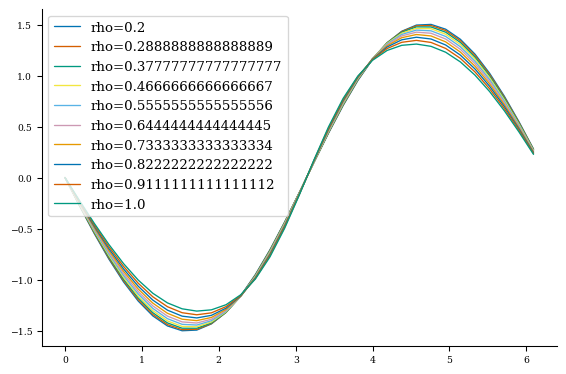

In [146]:
rhos = np.linspace(0.2, 1, 10)
for rho in rhos:
    grid_vec = LinearGrid(rho=rho, M=16, N=0, NFP=eq.NFP, sym=False)
    et = eq.compute("e^theta", grid=grid_vec)["e^theta"]
    plt.plot(grid_vec.nodes[:, 1], et[:, 0] * grid_vec.nodes[:, 0], label=f"rho={rho}")
plt.legend()

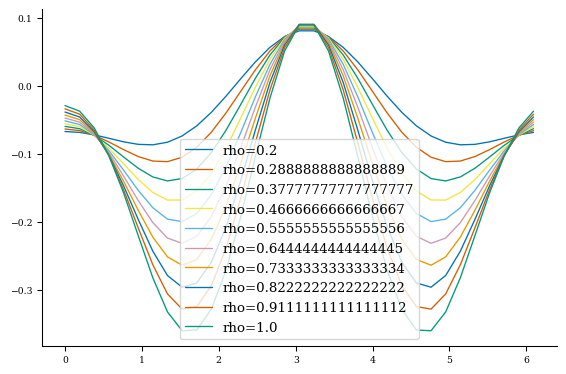

In [147]:
rhos = np.linspace(0.2, 1, 10)
for rho in rhos:
    grid_vec = LinearGrid(rho=rho, M=16, N=0, NFP=eq.NFP, sym=False)
    et = eq.compute("e^theta", grid=grid_vec)["e^theta"]
    plt.plot(grid_vec.nodes[:, 1], et[:, 1]*grid_vec.nodes[:, 0], label=f"rho={rho}")
plt.legend()

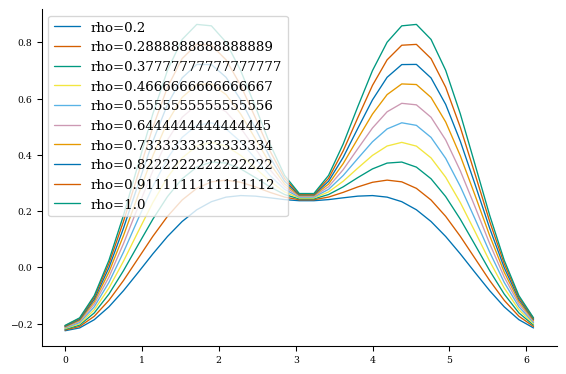

In [148]:
rhos = np.linspace(0.2, 1, 10)
for rho in rhos:
    grid_vec = LinearGrid(rho=rho, M=16, N=0, NFP=eq.NFP, sym=False)
    et = eq.compute("e^theta", grid=grid_vec)["e^theta"]
    plt.plot(grid_vec.nodes[:, 1], et[:, 2]*grid_vec.nodes[:, 0], label=f"rho={rho}")
plt.legend()

In [143]:
rhos = np.linspace(0.2, 1, 10)
thetas = grid_vec.nodes[:, 1]
zeta = 0

ers = []
eps = []
ezs = []

for rho in rhos:
    idr = []
    idp = []
    idz = []

    for theta in thetas:
        r0p = 1 - 2 * rho
        Tl = jnp.cos(data["l"] * jnp.arccos(r0p))
        m_theta = data["m"] * theta
        expm_real = jnp.cos(m_theta) / data["M"]
        expm_imag = jnp.sin(m_theta) / data["M"]

        n_zeta = data["n"] * zeta
        expn_real = jnp.cos(n_zeta) / data["N"]
        expn_imag = jnp.sin(n_zeta) / data["N"]

        def interpolate(cf_real, cf_imag):
            # This function now manually performs complex arithmetic

            # 1. f_l = (cf_real + i*cf_imag) * Tl  (Tl is real)
            f_l_real = jnp.einsum("nlm,l->nm", cf_real, Tl)
            f_l_imag = jnp.einsum("nlm,l->nm", cf_imag, Tl)

            # 2. f_lm = (f_l_real + i*f_l_imag) * (expm_real + i*expm_imag)
            f_lm_real = jnp.einsum("nm,m->n", f_l_real, expm_real) - jnp.einsum(
                "nm,m->n", f_l_imag, expm_imag
            )
            f_lm_imag = jnp.einsum("nm,m->n", f_l_real, expm_imag) + jnp.einsum(
                "nm,m->n", f_l_imag, expm_real
            )

            # 3. f_lmn = (f_lm_real + i*f_lm_imag) * (expn_real + i*expn_imag)
            # We only need the final real part: Real(A*B) = A_real*B_real - A_imag*B_imag
            f_lmn_real = jnp.einsum("n,n->", f_lm_real, expn_real) - jnp.einsum(
                "n,n->", f_lm_imag, expn_imag
            )

            return f_lmn_real

        et_r = interpolate(data["et_r_real"], data["et_r_imag"])
        et_p = interpolate(data["et_p_real"], data["et_p_imag"])
        et_z = interpolate(data["et_z_real"], data["et_z_imag"])

        idr.append(et_r)
        idp.append(et_p)
        idz.append(et_z)

    ers.append(idr)
    eps.append(idp)
    ezs.append(idz)

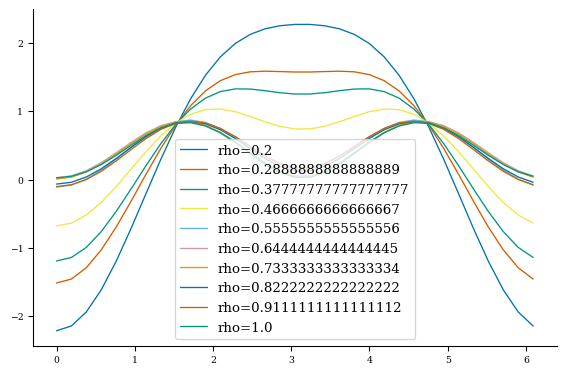

In [144]:
ers = np.array(ers)
eps = np.array(eps)
ezs = np.array(ezs)
for i, er in enumerate(ezs):
    plt.plot(thetas, er, label=f"rho={rhos[i]}")
plt.legend()

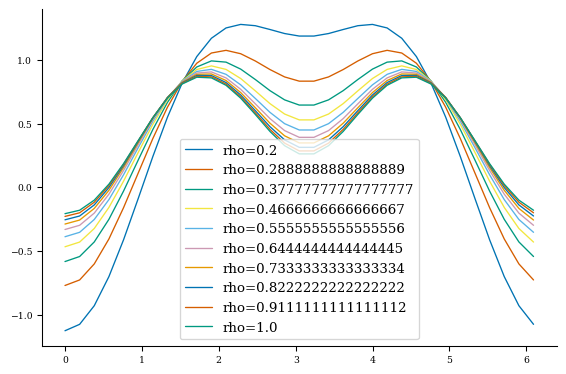

In [145]:
rhos = np.linspace(0.2, 1, 10)
for rho in rhos:
    grid_vec = LinearGrid(rho=rho, M=16, N=0, NFP=eq.NFP, sym=False)
    et = eq.compute("e^theta", grid=grid_vec)["e^theta"]
    plt.plot(grid_vec.nodes[:, 1], et[:, 2], label=f"rho={rho}")
plt.legend()

# Compute $e^\theta$ separately

In [125]:
class VacuumGuidingCenterTrajectoryFitRealTheta(AbstractTrajectoryModel):
    vcoords = ["vpar"]
    args = ["m", "q", "mu"]

    def __init__(self, frame):
        assert frame in ["lab", "flux"]
        self._frame = frame

    @property
    def frame(self):
        """Coordinate frame of the model."""
        return self._frame

    @jit
    def vf(self, t, x, args):
        x = x.squeeze()
        model_args, data, params, eqdict = args
        eq = eqdict["eq"]
        m, q, mu = model_args

        xp, yp, zeta, vpar = x
        rho = jnp.sqrt(xp**2 + yp**2)
        theta = jnp.arctan2(yp, xp)
        # compute functions are not correct for very small rho
        rho = jnp.where(rho < 1e-6, 1e-6, rho)

        grid = Grid(
            jnp.array([rho, theta, zeta]).T,
            spacing=jnp.zeros((3,)).T,
            jitable=True,
        )
        data_keys = "e^theta"

        transforms = get_transforms(data_keys, eq, grid, jitable=True)
        profiles = {"iota": eq.iota}
        et = compute_fun(
            "desc.equilibrium.equilibrium.Equilibrium",
            data_keys,
            params,
            transforms,
            profiles,
        )["e^theta"].squeeze()

        r0p = 1 - 2 * rho
        Tl = jnp.cos(data["l"] * jnp.arccos(r0p))
        m_theta = data["m"] * theta
        expm_real = jnp.cos(m_theta) / data["M"]
        expm_imag = jnp.sin(m_theta) / data["M"]

        n_zeta = data["n"] * zeta
        expn_real = jnp.cos(n_zeta) / data["N"]
        expn_imag = jnp.sin(n_zeta) / data["N"]

        def interpolate(cf_real, cf_imag):
            # This function now manually performs complex arithmetic

            # 1. f_l = (cf_real + i*cf_imag) * Tl  (Tl is real)
            f_l_real = jnp.einsum("nlm,l->nm", cf_real, Tl)
            f_l_imag = jnp.einsum("nlm,l->nm", cf_imag, Tl)

            # 2. f_lm = (f_l_real + i*f_l_imag) * (expm_real + i*expm_imag)
            f_lm_real = jnp.einsum("nm,m->n", f_l_real, expm_real) - jnp.einsum(
                "nm,m->n", f_l_imag, expm_imag
            )
            f_lm_imag = jnp.einsum("nm,m->n", f_l_real, expm_imag) + jnp.einsum(
                "nm,m->n", f_l_imag, expm_real
            )

            # 3. f_lmn = (f_lm_real + i*f_lm_imag) * (expn_real + i*expn_imag)
            # We only need the final real part: Real(A*B) = A_real*B_real - A_imag*B_imag
            f_lmn_real = jnp.einsum("n,n->", f_lm_real, expn_real) - jnp.einsum(
                "n,n->", f_lm_imag, expn_imag
            )

            return f_lmn_real

        Br = interpolate(data["Br_real"], data["Br_imag"])
        Bp = interpolate(data["Bp_real"], data["Bp_imag"])
        Bz = interpolate(data["Bz_real"], data["Bz_imag"])
        B = jnp.array([Br, Bp, Bz])
        magB = jnp.linalg.norm(B)
        b = B / magB

        gBr = interpolate(data["gBr_real"], data["gBr_imag"])
        gBp = interpolate(data["gBp_real"], data["gBp_imag"])
        gBz = interpolate(data["gBz_real"], data["gBz_imag"])
        gradB = jnp.array([gBr, gBp, gBz])

        er_r = interpolate(data["er_r_real"], data["er_r_imag"])
        er_p = interpolate(data["er_p_real"], data["er_p_imag"])
        er_z = interpolate(data["er_z_real"], data["er_z_imag"])
        er = jnp.array([er_r, er_p, er_z])

        ez_r = interpolate(data["ez_r_real"], data["ez_r_imag"])
        ez_p = interpolate(data["ez_p_real"], data["ez_p_imag"])
        ez_z = interpolate(data["ez_z_real"], data["ez_z_imag"])
        ez = jnp.array([ez_r, ez_p, ez_z])

        Rdot = vpar * b + (
            (m / q / magB**2) * ((mu * magB / m) + vpar**2) * cross(b, gradB)
        )
        # take dot product for rho, theta and zeta coordinates
        rhodot = dot(Rdot, er)
        thetadot = dot(Rdot, et)
        zetadot = dot(Rdot, ez)

        # get the derivative for cartesian-like coordinates
        xpdot = rhodot * jnp.cos(theta) - rho * thetadot * jnp.sin(theta)
        ypdot = rhodot * jnp.sin(theta) + rho * thetadot * jnp.cos(theta)
        # derivative the parallel velocity
        vpardot = -mu / m * dot(b, gradB)
        dxdt = jnp.array([xpdot, ypdot, zetadot, vpardot]).reshape(x.shape)
        return dxdt.squeeze()

In [136]:
from desc.particles import _trace_particles

model_real_theta = VacuumGuidingCenterTrajectoryFitRealTheta(frame="flux")
model_org = VacuumGuidingCenterTrajectory(frame="flux")


def default_event(t, y, args, **kwargs):
    i = jnp.sqrt(y[0] ** 2 + y[1] ** 2)
    return jnp.logical_or(i < 0.0, i > 1.0)


event = Event(default_event)
T = 4
ts = np.linspace(0, 10 ** (-T), 100)
num = 10
rhos = [0.7] * num
initializer = ManualParticleInitializerFlux(
    rho0=rhos,
    theta0=0.5,
    zeta0=np.random.rand(num) * 2 * np.pi,
    xi0=2 * np.random.rand(num) - 1,
)
x0, args = initializer.init_particles(model=model_real_theta, field=eq)


@jit
def fun(x0, args):
    rpz, _ = _trace_particles(
        field=data,
        y0=x0,
        model=model_real_theta,
        model_args=args,
        ts=ts,
        params=eq.params_dict,
        max_steps=1000,
        min_step_size=1e-8,
        stepsize_controller=PIDController(rtol=1e-4, atol=1e-4, dtmin=1e-8),
        saveat=SaveAt(ts=ts),
        solver=Tsit5(),
        adjoint=RecursiveCheckpointAdjoint(),
        event=event,
        chunk_size=None,
        options={"eq": eq},
        throw=True,
        return_aux=False,
    )
    return rpz


@jit
def fun_org(x0, args):
    rpz, _ = _trace_particles(
        field=eq,
        y0=x0,
        model=model_org,
        model_args=args,
        ts=ts,
        params=eq.params_dict,
        max_steps=1000,
        min_step_size=1e-8,
        stepsize_controller=PIDController(rtol=1e-4, atol=1e-4, dtmin=1e-8),
        saveat=SaveAt(ts=ts),
        solver=Tsit5(),
        adjoint=RecursiveCheckpointAdjoint(),
        event=event,
        chunk_size=None,
        options={},
        throw=True,
        return_aux=False,
    )
    return rpz

In [137]:
x00 = x0[0]
params = eq.params_dict
%timeit model_real_theta.vf(0, x00, [args[0], data, params, {"eq": eq}])
%timeit model_org.vf(0, x00, [args[0], eq, params, {}])

2.24 ms ± 28.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.27 ms ± 181 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
